In [1]:
import tensorflow as tf
tf.__version__

'2.1.0'

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense,Activation,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization,Reshape,Input
from tensorflow.keras.layers import AveragePooling2D,concatenate,Input,concatenate,Concatenate,GlobalAveragePooling2D,Add
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger,LearningRateScheduler,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.python.framework import graph_util
import numpy as np

from tensorflow.keras.layers import ZeroPadding2D

tf.device('/gpu:1')

#import os
#os.environ['CUDA_VISIBLE_DEVICES']='0'

"""
cfg = tf.ConfigProto() 
cfg.gpu_options.per_process_gpu_memory_fraction = 0.5 # 使用50%的GPU暫存  
session = tf.Session(config=cfg )
"""

'\ncfg = tf.ConfigProto() \ncfg.gpu_options.per_process_gpu_memory_fraction = 0.5 # 使用50%的GPU暫存  \nsession = tf.Session(config=cfg )\n'

In [3]:
def model_resnet50(width=224,height=224,channel=3,classes=100):
    def Conv2d_BN(x, nb_filter, kernel_size, strides=(1, 1), padding='same', name=None):
        if name is not None:
            bn_name = name+'_bn'
            conv_name = name+'_conv'
        else:
            bn_name = None
            conv_name = None
            x = Conv2D(nb_filter, kernel_size, padding=padding, strides=strides, activation='relu', name=conv_name)(x)
            x = BatchNormalization(axis=3, name=bn_name)(x)
        return x
    def bottleneck_Block(inpt,nb_filters,strides=(1,1),with_conv_shortcut=False):
        k1,k2,k3=nb_filters
        x = Conv2d_BN(inpt, nb_filter=k1, kernel_size=1, strides=strides, padding='same')
        x = Conv2d_BN(x, nb_filter=k2, kernel_size=3, padding='same')
        x = Conv2d_BN(x, nb_filter=k3, kernel_size=1, padding='same')
        if with_conv_shortcut:
            shortcut = Conv2d_BN(inpt, nb_filter=k3, strides=strides, kernel_size=1)
            x = Add()([x, shortcut])
            return x
        else:
            x = Add()([x, inpt])
            return x
    input_x = Input(shape=(width,height,channel),name='input_x')
    x = BatchNormalization(axis=3)(input_x)

    x = ZeroPadding2D((3, 3))(x)
    x = Conv2d_BN(x, nb_filter=64, kernel_size=(7, 7), strides=(2, 2), padding='valid')
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    #conv2_x
    x = bottleneck_Block(x, nb_filters=[64,64,256],strides=(1,1),with_conv_shortcut=True)
    x = bottleneck_Block(x, nb_filters=[64,64,256])
    x = bottleneck_Block(x, nb_filters=[64,64,256])
    #conv3_x
    x = bottleneck_Block(x, nb_filters=[128, 128, 512],strides=(2,2),with_conv_shortcut=True)
    x = bottleneck_Block(x, nb_filters=[128, 128, 512])
    x = bottleneck_Block(x, nb_filters=[128, 128, 512])
    x = bottleneck_Block(x, nb_filters=[128, 128, 512])
    #conv4_x
    x = bottleneck_Block(x, nb_filters=[256, 256, 1024],strides=(2,2),with_conv_shortcut=True)
    x = bottleneck_Block(x, nb_filters=[256, 256, 1024])
    x = bottleneck_Block(x, nb_filters=[256, 256, 1024])
    x = bottleneck_Block(x, nb_filters=[256, 256, 1024])
    x = bottleneck_Block(x, nb_filters=[256, 256, 1024])
    x = bottleneck_Block(x, nb_filters=[256, 256, 1024])
    #conv5_x
    x = bottleneck_Block(x, nb_filters=[512, 512, 2048], strides=(2, 2), with_conv_shortcut=True)
    x = bottleneck_Block(x, nb_filters=[512, 512, 2048])
    x = bottleneck_Block(x, nb_filters=[512, 512, 2048])
    x = AveragePooling2D(pool_size=(7, 7))(x)
    x = Flatten()(x)
    output_x = Dense(classes, activation='softmax',name='output_x')(x)
    return Model(inputs=input_x,outputs=output_x)


In [4]:
save_path='model_resnet50_100.h5'
width=224
height=224
channel=3
classes=3
batch_sizes=16
epochs=200
K.clear_session()

In [5]:
model=model_resnet50(width,height,channel,classes)
model.summary()
######
#train='C:\\Users\\es402a\\Desktop\\forrobotclass\\train100\\train'
#valid='C:\\Users\\es402a\\Desktop\\forrobotclass\\train100\\valid'

train='./train'
valid='./test'

train_datagen = ImageDataGenerator(rescale=1. / 255,rotation_range=0,width_shift_range=0, height_shift_range=0, horizontal_flip=False, dtype=np.float32) 

valid_datagen = ImageDataGenerator(rescale=1.0/255,dtype=np.float32)
                                   
#print('OK')
                                   
train_batches = train_datagen.flow_from_directory(train,target_size=(width,height),color_mode='rgb',class_mode='categorical',batch_size=batch_sizes)
valid_batches = valid_datagen.flow_from_directory(valid,target_size=(width,height),color_mode='rgb',class_mode='categorical',batch_size=batch_sizes)
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx,cls))
    
ReduceLr = ReduceLROnPlateau(monitor='val_loss',factor=0.7,patience=5,verbose=1)
checkpointer = ModelCheckpoint(filepath=save_path,monitor='val_accuracy',verbose=1,save_best_only=True)
trainlog = CSVLogger(str(save_path)[:-3]+'.csv',append=False)
model.compile(optimizer=SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False),loss = 'categorical_crossentropy',metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_x (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 3)  12          input_x[0][0]                    
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        zero_padding2d[0][0]             
______________________________________________________________________________________________

In [6]:
History = model.fit_generator(train_batches,steps_per_epoch = len(train_batches),validation_data=valid_batches,validation_steps = len(valid_batches),workers=24,epochs = int(epochs),callbacks = [checkpointer,ReduceLr,trainlog])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 94 steps, validate for 27 steps
Epoch 1/200
93/94 [============================>.] - ETA: 0s - loss: 0.3038 - accuracy: 0.8972
Epoch 00001: val_accuracy improved from -inf to 0.14252, saving model to model_resnet50_100.h5
94/94 [==============================] - 64s 677ms/step - loss: 0.3008 - accuracy: 0.8983 - val_loss: 2.0357 - val_accuracy: 0.1425
Epoch 2/200
93/94 [============================>.] - ETA: 0s - loss: 0.0284 - accuracy: 0.9939
Epoch 00002: val_accuracy improved from 0.14252 to 0.38551, saving model to model_resnet50_100.h5
94/94 [==============================] - 52s 554ms/step - loss: 0.0283 - accuracy: 0.9940 - val_loss: 1.3026 - val_accuracy: 0.3855
Epoch 3/200
93/94 [============================>.] - ETA: 0s - loss: 0.0108 - accuracy: 0.9986
Epoch 00003: val_accuracy improved from 0.38551 to 0.51869, saving model to model_resnet50

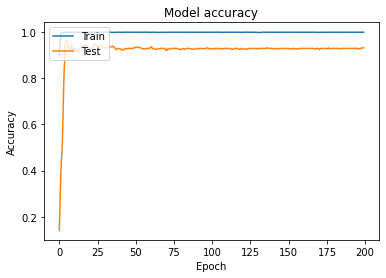

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Test'],loc='upper left')
plt.show()


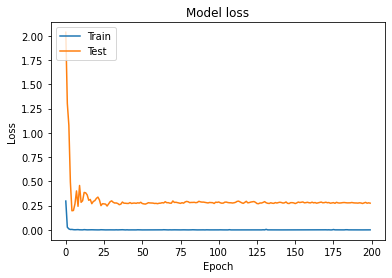

In [8]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

In [9]:
from tensorflow.python.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.models import Model
import numpy as np
# 讀取模型
K.clear_session()

In [10]:
modelpath='.\model_resnet50_100.h5'
model=load_model(modelpath)
width=224
height=224
channel=3
classes=2
batch_sizes=16

datagen2 = ImageDataGenerator(rescale=1. / 255)

#######
testfile='./'
generatorVal = datagen2.flow_from_directory( testfile,target_size=(height,width),color_mode='rgb',class_mode='categorical',batch_size=batch_sizes,shuffle=False)


# 測試模型
#generator.reset()
History = model.predict_generator(generatorVal,
len(generatorVal),
verbose=1)
for i in range(0,generatorVal.labels.shape[0]):
    print(generatorVal.filepaths[i])
    print(generatorVal.labels[i],' ',np.argmax(History[i]),' ',np.round(History[i],3))                                   


                                            
                                            
                                            

Found 1922 images belonging to 3 classes.
Instructions for updating:
Please use Model.predict, which supports generators.
121/121 [==============================] - 102s 841ms/step
./test\left\IMG_5870.JPG
1   0   [1. 0. 0.]
./test\left\IMG_5871.JPG
1   0   [1. 0. 0.]
./test\left\IMG_5883.JPG
1   0   [1. 0. 0.]
./test\left\IMG_5884.JPG
1   0   [1. 0. 0.]
./test\left\IMG_5896.JPG
1   0   [0.93 0.   0.07]
./test\left\IMG_5897.JPG
1   0   [0.844 0.    0.156]
./test\left\IMG_5909.JPG
1   0   [0.998 0.002 0.001]
./test\left\IMG_5910.JPG
1   0   [0.999 0.001 0.   ]
./test\left\IMG_5922.JPG
1   0   [0.976 0.02  0.004]
./test\left\IMG_5923.JPG
1   0   [0.973 0.02  0.006]
./test\left\IMG_5935.JPG
1   0   [1. 0. 0.]
./test\left\IMG_5936.JPG
1   0   [1. 0. 0.]
./test\left\IMG_5948.JPG
1   0   [1. 0. 0.]
./test\left\IMG_5949.JPG
1   0   [1. 0. 0.]
./test\left\IMG_5961.JPG
1   0   [1. 0. 0.]
./test\left\IMG_5962.JPG
1   0   [1. 0. 0.]
./test\left\IMG_5974.JPG
1   0   [0.988 0.011 0.001]
./test\left